# Human Activity Recognition (HAR) - Training

This notebook trains an EfficientNet model for Human Activity Recognition.


## 1. Import Libraries


In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint
)
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import joblib


## 2. Load Data


In [ ]:
# Load training data CSV
train_data = pd.read_csv("Dataset/Training_set.csv").sample(100)
train_folder = "Dataset/train"

print(f"Training data shape: {train_data.shape}")
print(f"\nFirst few rows:")
print(train_data.head())
print(f"\nLabel distribution:")
print(train_data.label.value_counts())


Training data shape: (12600, 2)

First few rows:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

Label distribution:
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


C:\Users\S\AppData\Local\Temp\ipykernel_3396\2585768241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


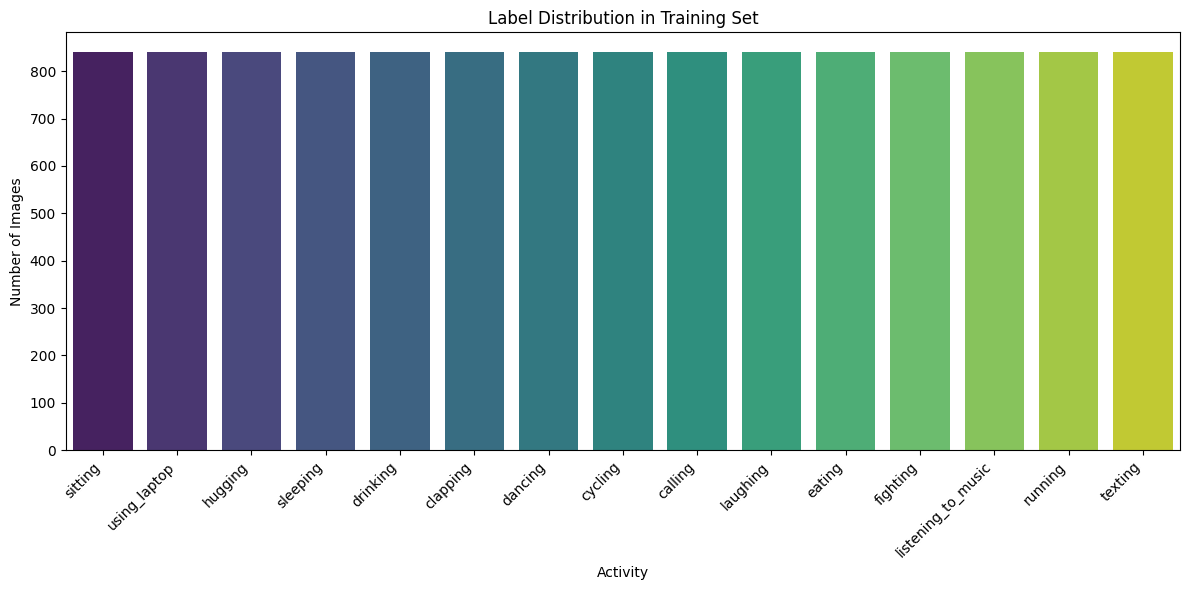

In [3]:
# Visualize label distribution
label_counts = train_data['label'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Label Distribution in Training Set')
plt.xlabel('Activity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. Data Visualization


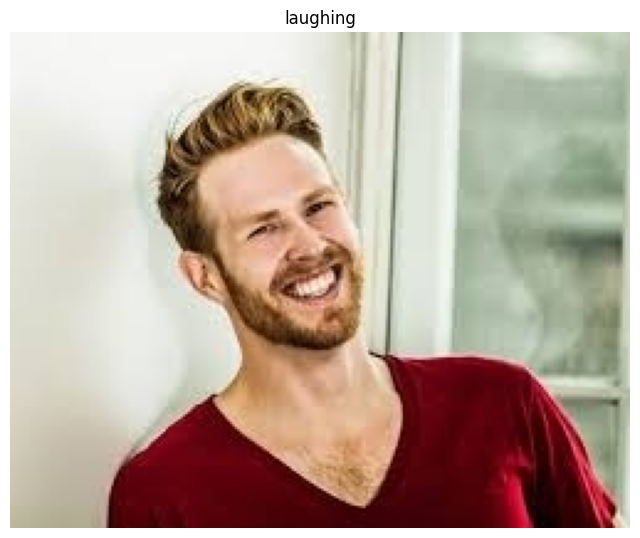

In [4]:
def displaying_random_images():
    num = random.randint(1, 12600)
    imgg = f"Image_{num}.jpg"
    img_path = os.path.join(train_folder, imgg)
    
    if os.path.exists(img_path):
        testImage = img.imread(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(testImage)
        label = train_data.loc[train_data['filename'] == imgg, 'label'].values
        if len(label) > 0:
            plt.title(f"{label[0]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"File not found: {img_path}")

displaying_random_images()


## 4. Data Preprocessing with ImageDataGenerator


In [5]:
# Augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


In [6]:
# Create generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_folder,
    x_col="filename",
    y_col="label",
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Save class names
class_names = list(train_gen.class_indices.keys())
joblib.dump(class_names, "class_names.pkl")
print("Class names:", class_names)
print(f"Train samples: {train_gen.samples}")
print(f"Val samples: {val_gen.samples}")


Found 10080 validated image filenames belonging to 15 classes.
Found 2520 validated image filenames belonging to 15 classes.
Class names: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train samples: 10080
Val samples: 2520


In [7]:
# Verify batch shape
x_batch, y_batch = next(train_gen)
print("Image batch shape:", x_batch.shape)
print("Label batch shape:", y_batch.shape)
print("First label (one-hot):", y_batch[0])
print("Class index:", np.argmax(y_batch[0]))
print("Activity name:", class_names[np.argmax(y_batch[0])])


Image batch shape: (32, 160, 160, 3)
Label batch shape: (32, 15)
First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class index: 3
Activity name: dancing


## 5. Build Model - EfficientNetB3


In [8]:
num_classes = len(class_names)

# EfficientNetB3 base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(160, 160, 3),
    pooling="avg",
    weights="imagenet"
)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build complete model
efficientnet_model = Sequential([
    base_model,
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Loss with label smoothing
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile model
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

efficientnet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,578,174 (44.17 MB)

 Trainable params: 794,639 (3.03 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## 6. Training - Stage 1 (Frozen Base)


In [ ]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train Stage 1
EPOCHS = 1
history_stage1 = efficientnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2515 - loss: 2.4266
Epoch 1: val_accuracy improved from None to 0.58294, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.3640 - loss: 2.1755 - val_accuracy: 0.5829 - val_loss: 1.6494 - learning_rate: 1.0000e-04
Epoch 2/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5079 - loss: 1.8042
Epoch 2: val_accuracy improved from 0.58294 to 0.62857, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.5199 - loss: 1.7769 - val_accuracy: 0.6286 - val_loss: 1.5092 - learning_rate: 1.0000e-04
Epoch 3/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.5448 - loss: 1.7102
Epoch 3: val_accuracy improved from 0.62857 to 0.63690, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.5570 - loss: 1.6875 - val_accuracy: 0.6369 - val_loss: 1.4710 - learning_rate: 1.0000e-04
Epoch 4/25
315/315 ━━━━━━━━━━━━━━━━━━━━ 

## 7. Training - Stage 2 (Fine-tune)


In [10]:
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=["accuracy"]
)

# Train Stage 2
history_stage2 = efficientnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5886 - loss: 1.6286
Epoch 1: val_accuracy did not improve from 0.69881
315/315 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - accuracy: 0.6066 - loss: 1.5789 - val_accuracy: 0.6472 - val_loss: 1.4802 - learning_rate: 1.0000e-05
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6183 - loss: 1.5130
Epoch 2: val_accuracy did not improve from 0.69881
315/315 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.6270 - loss: 1.5023 - val_accuracy: 0.6579 - val_loss: 1.4502 - learning_rate: 1.0000e-05
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6491 - loss: 1.4761
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 3: val_accuracy did not improve from 0.69881
315/315 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.6452 - loss: 1.4702 - val_accuracy: 0.6663 - val_loss: 1.4298 - learning_rate: 1.0000e-05
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6492 - loss

## 8. Visualize Training History


In [13]:
# Evaluate model on validation set for visualization purposes
val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
val_predictions = efficientnet_model.predict(val_gen, steps=val_steps, verbose=1)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_gen.classes
confidence_scores = np.max(val_predictions, axis=1)

cm = confusion_matrix(val_true_classes, val_pred_classes)
report = classification_report(val_true_classes, val_pred_classes, target_names=class_names)
print(report)



79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step
                    precision    recall  f1-score   support

           calling       0.49      0.50      0.50       156
          clapping       0.72      0.55      0.62       176
           cycling       0.92      0.93      0.93       165
           dancing       0.62      0.70      0.66       147
          drinking       0.61      0.66      0.63       165
            eating       0.80      0.85      0.82       173
          fighting       0.71      0.67      0.69       178
           hugging       0.63      0.59      0.61       185
          laughing       0.58      0.63      0.61       177
listening_to_music       0.43      0.44      0.43       151
           running       0.79      0.74      0.76       155
           sitting       0.54      0.48      0.51       173
          sleeping       0.65      0.82      0.73       178
           texting       0.48      0.39      0.43       158
      using_laptop       0.69      0.73      0.71       183

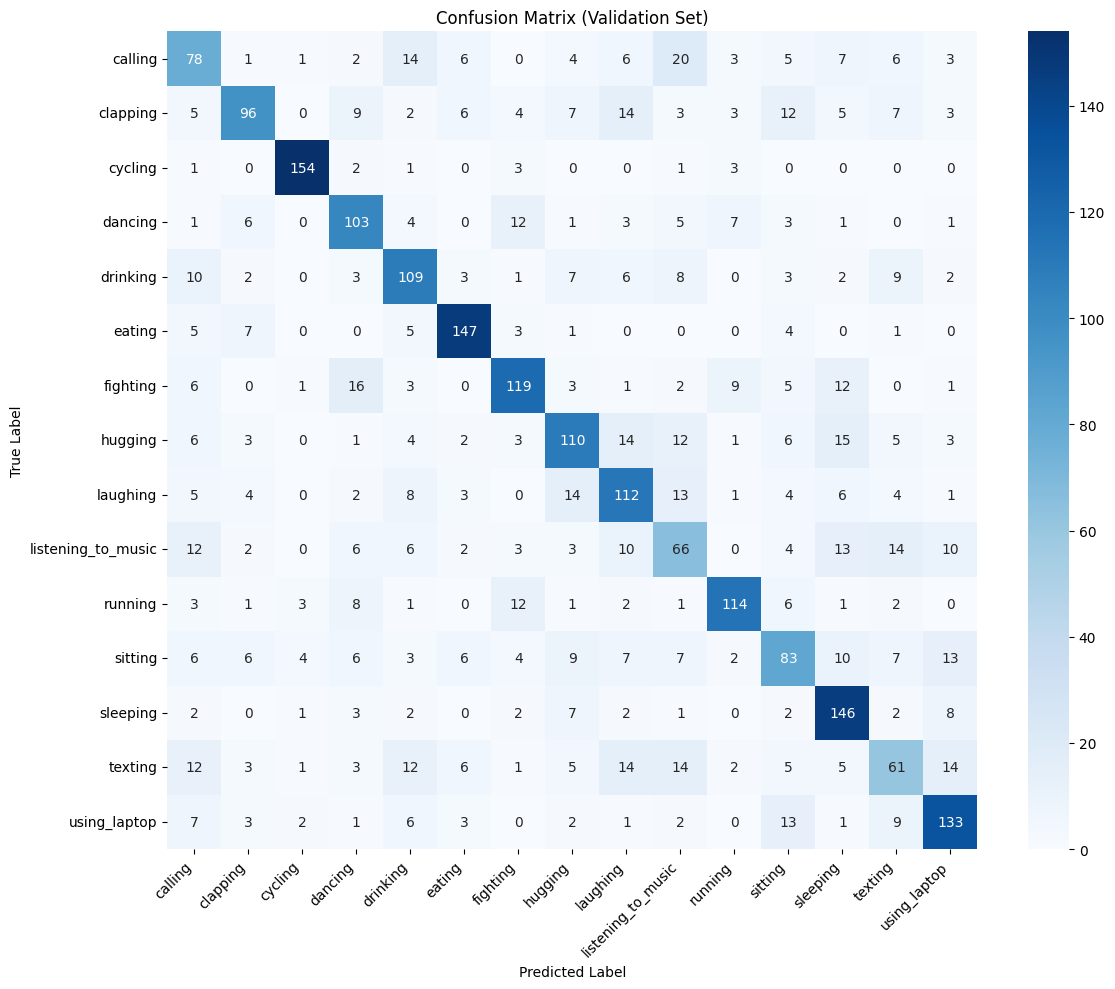

In [14]:
# Confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\S\AppData\Local\Temp\ipykernel_3396\3568113825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_accuracy, palette='crest')


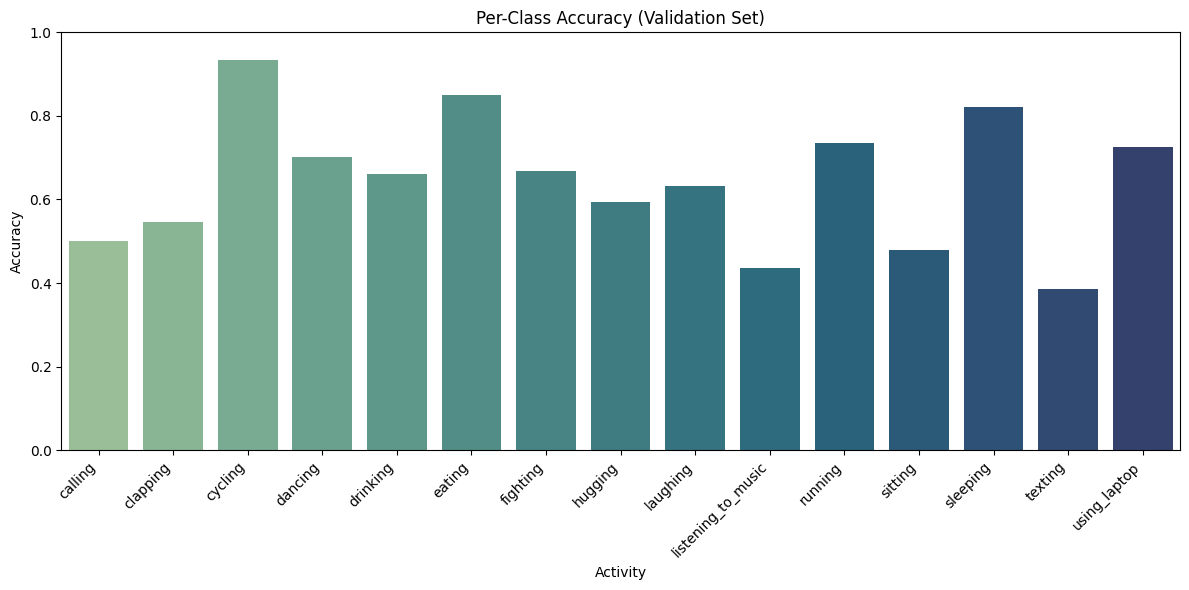

In [15]:
# Per-class accuracy chart
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy, palette='crest')
plt.ylim(0, 1)
plt.title('Per-Class Accuracy (Validation Set)')
plt.xlabel('Activity')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


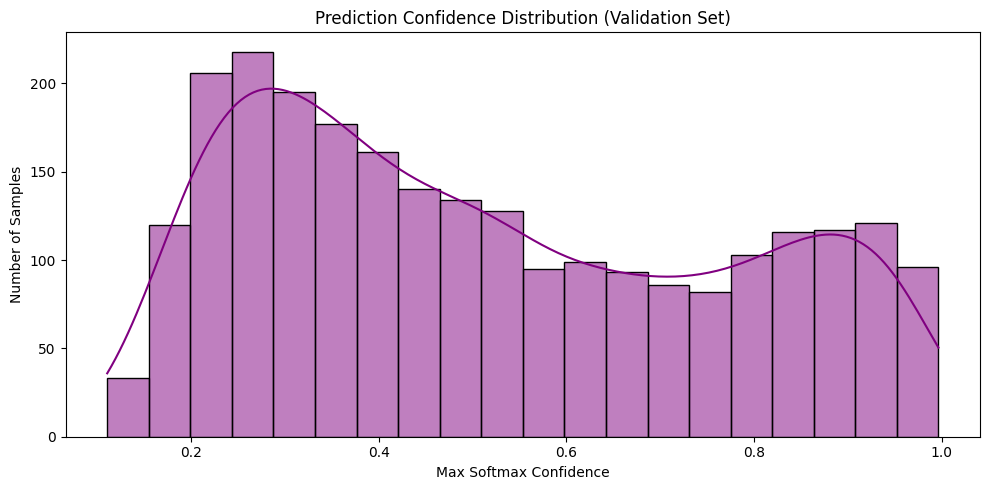

In [16]:
# Prediction confidence distribution
plt.figure(figsize=(10, 5))
sns.histplot(confidence_scores, bins=20, kde=True, color='purple')
plt.title('Prediction Confidence Distribution (Validation Set)')
plt.xlabel('Max Softmax Confidence')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()



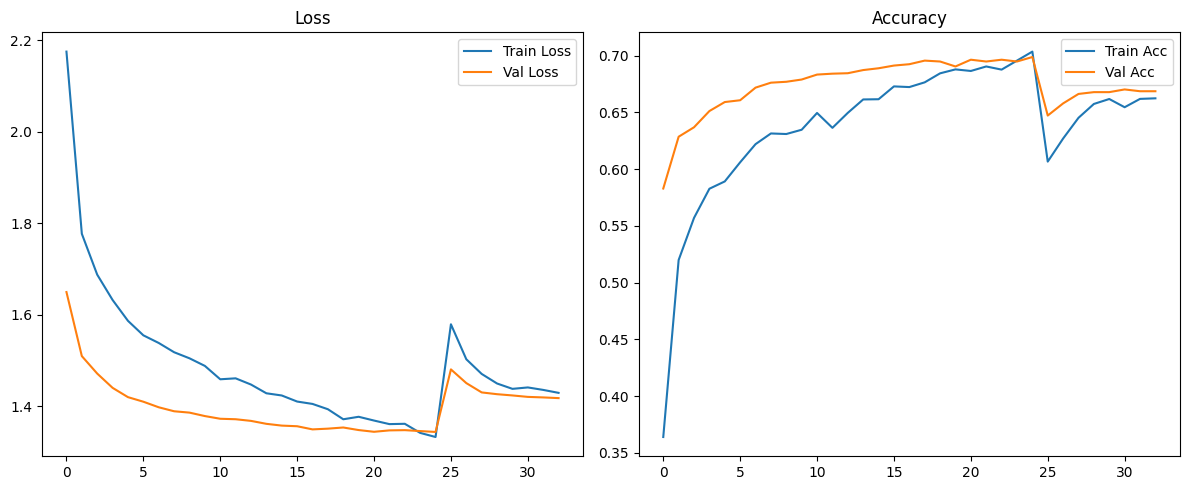

Best Val Accuracy: 69.88%


In [17]:
# Combine histories
history_combined = {
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'],
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
}

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_combined['loss'], label='Train Loss')
plt.plot(history_combined['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_combined['accuracy'], label='Train Acc')
plt.plot(history_combined['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print(f"Best Val Accuracy: {max(history_combined['val_accuracy'])*100:.2f}%")


## 9. Save Final Model


In [18]:
# Load the best model (saved by ModelCheckpoint callback) and save as final model
# This ensures we use the model with best validation accuracy
if os.path.exists('best_model.keras'):
    print("Loading best model (best validation accuracy)...")
    best_model = tf.keras.models.load_model('best_model.keras')
    best_model.save('activity_recognition_model.keras')
    print("Best model saved as 'activity_recognition_model.keras'")
else:
    # Fallback: save current model
    efficientnet_model.save('activity_recognition_model.keras')
    print("Model saved as 'activity_recognition_model.keras'")

print("Class names saved as 'class_names.pkl'")


Loading best model (best validation accuracy)...
Best model saved as 'activity_recognition_model.keras'
Class names saved as 'class_names.pkl'
